# Datasets description

En este trabajo se consideran tres tipos de fuentes de datos, cada una con un propósito específico dentro del marco metodológico: dataset sintético, datasets benchmark y dataset de datos reales provenientes de dispositivos comerciales.

## 1. Dataset sintético

El dataset sintético fue diseñado y generado específicamente para esta investigación. Su objetivo principal es proporcionar un entorno controlado que permita:
	•	Probar hipótesis bajo condiciones bien definidas.
	•	Realizar pruebas preliminares de consistencia y estabilidad de las arquitecturas propuestas.

Características principales:
	•	Variables simuladas inspiradas en señales fisiológicas (frecuencia cardiaca, respiratoria, temperatura, actividad, etc.).
	•	Inclusión intencional de patrones de irregularidad y faltantes no aleatorios, para reflejar condiciones típicas en datos médicos reales.
	•	Escenarios configurables: número de sujetos, longitud de las series, proporción de ruido y de artefactos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# Paths (ajusta si tu notebook tiene otra ruta)
PATH_SLEEP = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/sleep_series.csv"
PATH_PROF  = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/user_profiles.csv"
PATH_LAB   = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/nightly_labeled.csv"   # tiene etiqueta y threshold
PATH_SCORE = "/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs/300/scored_labeled.csv"    # tiene recovery_score_0_1

sleep = pd.read_csv(PATH_SLEEP, parse_dates=["night_date"])
prof  = pd.read_csv(PATH_PROF)
lab   = pd.read_csv(PATH_LAB, parse_dates=["night_date"])
score = pd.read_csv(PATH_SCORE, parse_dates=["night_date"])

# Unificamos en una tabla "night-level" con score + label
df = sleep.merge(score[["user_id","night_date","recovery_score_0_1"]],
                 on=["user_id","night_date"], how="left") \
          .merge(lab[["user_id","night_date","recovery_threshold","recovery_label_binary"]],
                 on=["user_id","night_date"], how="left")

# Limpieza de etiqueta (por si viene como string)
def label_to_int(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, np.integer, float, np.floating)):
        return int(x)
    x = str(x).strip().lower()
    if "adequate" in x:
        return 1
    if "deficient" in x:
        return 0
    return np.nan

df["y"] = df["recovery_label_binary"].apply(label_to_int)

# Orden temporal
df = df.sort_values(["user_id","night_date"]).reset_index(drop=True)

print("Rows (nights):", len(df))
print("Users:", df["user_id"].nunique())
print(df.columns.tolist())

Rows (nights): 28741
Users: 300
['user_id', 'night_date', 'total_hours', 'deep_minutes', 'rem_minutes', 'awake_minutes', 'sleep_latency_minutes', 'awakenings', 'failure_minutes', 'recovery_score_0_1', 'recovery_threshold', 'recovery_label_binary', 'y']


In [2]:
n_nights_per_user = df.groupby("user_id")["night_date"].count().sort_values(ascending=False)
example_user = int(n_nights_per_user.index[0])

print("Example user:", example_user, "| nights:", int(n_nights_per_user.iloc[0]))

u = df[df["user_id"] == example_user].copy()
u_prof = prof[prof["user_id"] == example_user].iloc[0].to_dict()
u.head()

Example user: 72 | nights: 281


,user_id,night_date,total_hours,deep_minutes,rem_minutes,awake_minutes,sleep_latency_minutes,awakenings,failure_minutes,recovery_score_0_1,recovery_threshold,recovery_label_binary,y
6397,72,2024-01-01,6.850000,179,35,87,1,39,34,0.354000,0.350502,Adequate Recovery,1
6398,72,2024-01-02,7.116667,150,26,108,1,50,42,0.364667,0.350502,Adequate Recovery,1
6399,72,2024-01-03,6.583333,155,35,80,1,30,50,0.343333,0.350502,Deficient Recovery,0
6400,72,2024-01-04,6.483333,104,27,111,6,40,13,0.315086,0.350502,Deficient Recovery,0
6401,72,2024-01-06,7.050000,130,43,114,5,44,42,0.362794,0.350502,Adequate Recovery,1


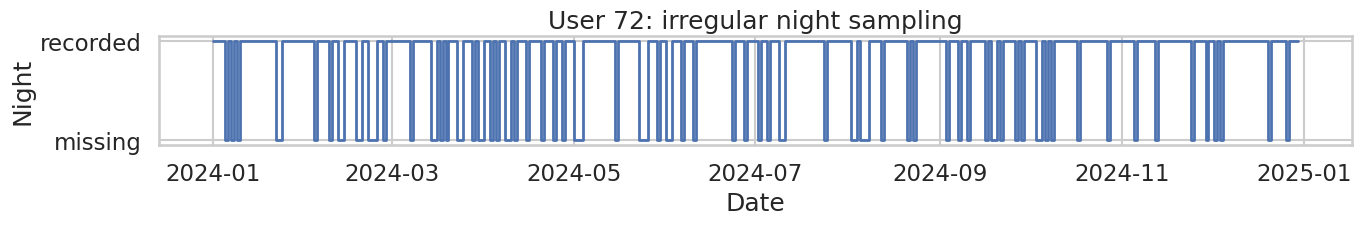

In [3]:
def plot_irregularity(u, title="Irregular sampling across nights"):
    dates = pd.to_datetime(u["night_date"]).sort_values()
    all_days = pd.date_range(dates.min(), dates.max(), freq="D")
    present = pd.Series(0, index=all_days)
    present.loc[dates.dt.normalize().unique()] = 1

    fig, ax = plt.subplots(figsize=(14, 2.6))
    ax.plot(present.index, present.values, drawstyle="steps-post", linewidth=2)
    ax.set_yticks([0,1])
    ax.set_yticklabels(["missing", "recorded"])
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Night")
    plt.tight_layout()
    return fig

plot_irregularity(u, title=f"User {example_user}: irregular night sampling")
plt.show()

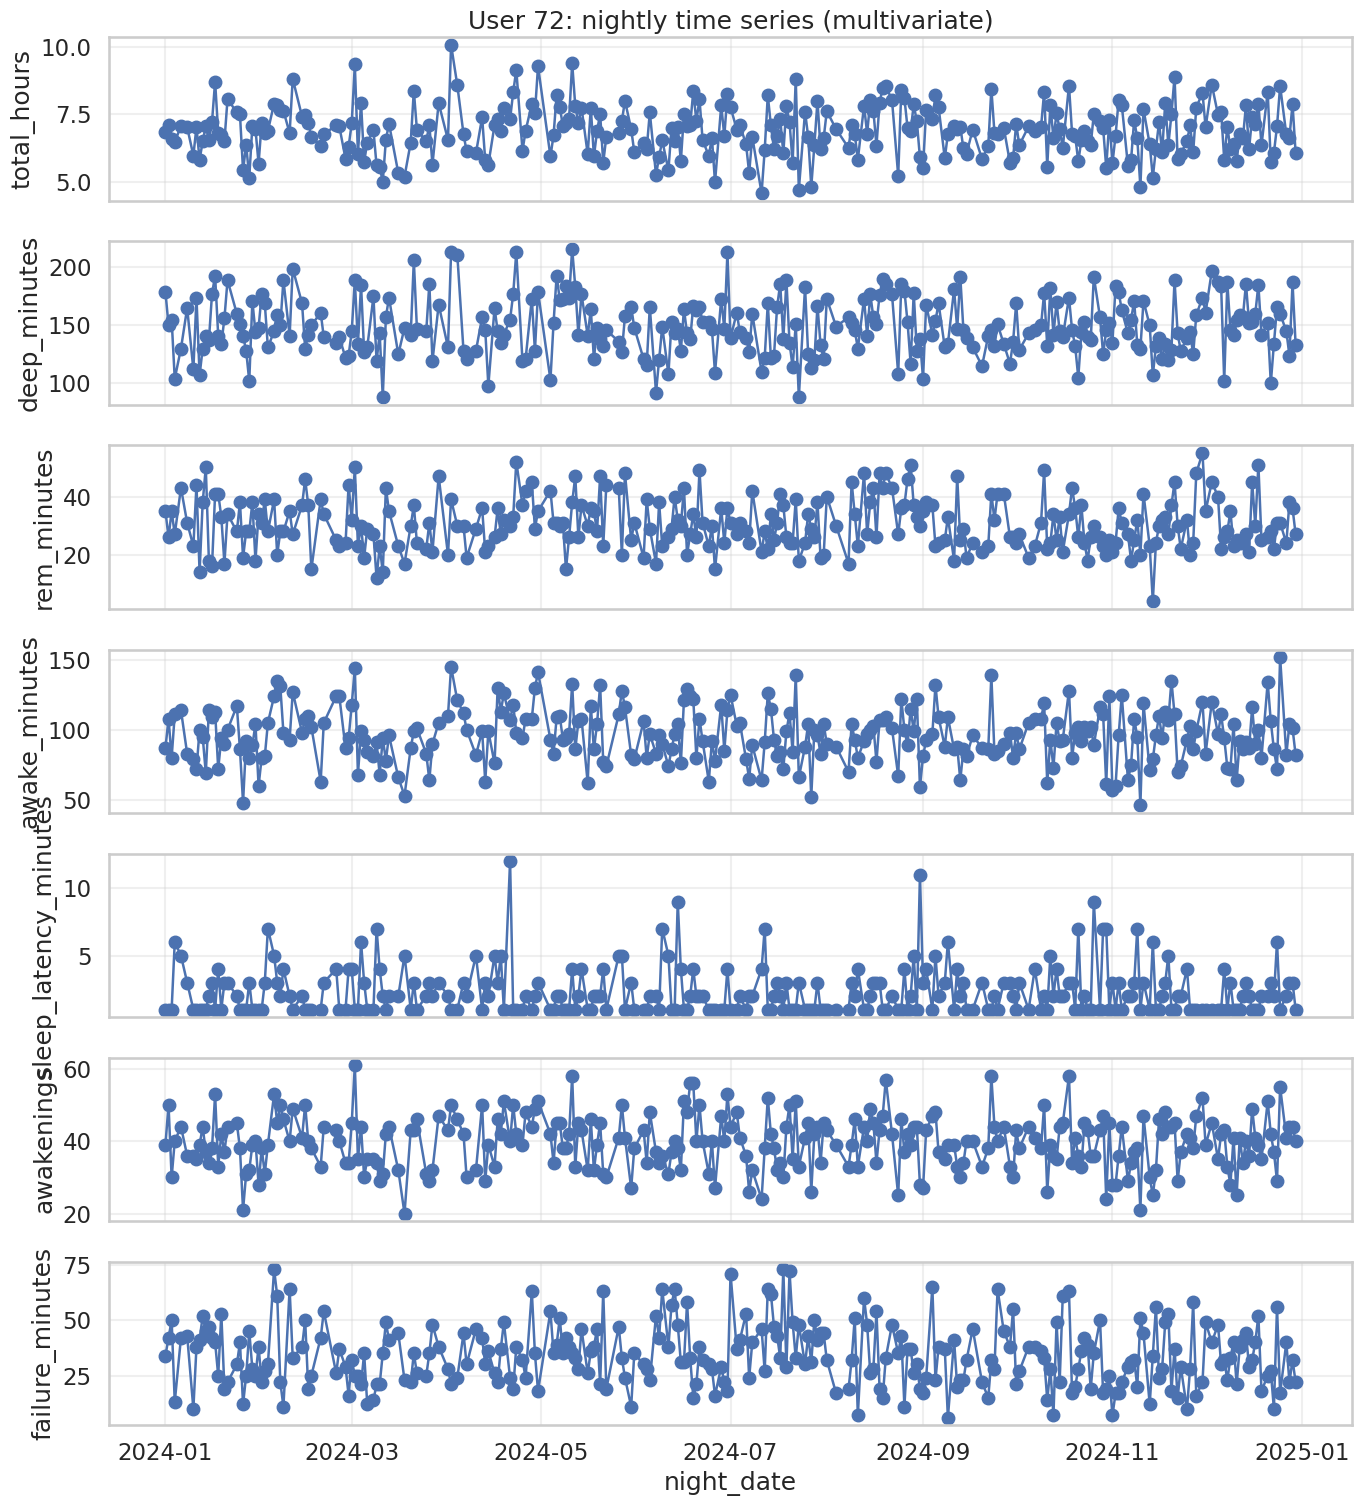

In [4]:
vars_to_plot = [
    "total_hours",
    "deep_minutes",
    "rem_minutes",
    "awake_minutes",
    "sleep_latency_minutes",
    "awakenings",
    "failure_minutes",
]

def plot_user_multivariate(u, vars_to_plot, title):
    n = len(vars_to_plot)
    fig, axes = plt.subplots(n, 1, figsize=(14, 2.2*n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, vars_to_plot):
        ax.plot(u["night_date"], u[col], marker="o", linewidth=1.8)
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3)

    axes[0].set_title(title)
    axes[-1].set_xlabel("night_date")
    plt.tight_layout()
    return fig

plot_user_multivariate(u, vars_to_plot, title=f"User {example_user}: nightly time series (multivariate)")
plt.show()

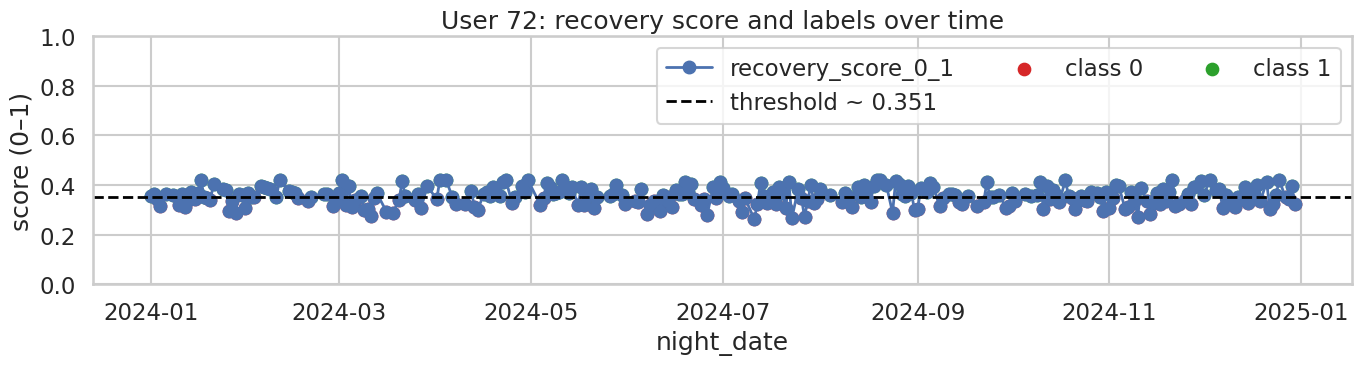

In [5]:
def plot_score_and_label(u, title):
    fig, ax = plt.subplots(figsize=(14, 4))

    ax.plot(u["night_date"], u["recovery_score_0_1"], marker="o", linewidth=2, label="recovery_score_0_1")

    # threshold (puede variar por noche o ser constante; tomamos mediana ignorando NaNs)
    thr = np.nanmedian(u["recovery_threshold"].values)
    if np.isfinite(thr):
        ax.axhline(thr, color="black", linestyle="--", linewidth=2, label=f"threshold ~ {thr:.3f}")

    # sombreado por clase (si existe)
    if u["y"].notna().any():
        # colorea puntos por clase
        palette = {0: "#d62728", 1: "#2ca02c"}
        for yval, g in u.dropna(subset=["y"]).groupby("y"):
            ax.scatter(g["night_date"], g["recovery_score_0_1"], s=70, color=palette[int(yval)], label=f"class {int(yval)}")

    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("night_date")
    ax.set_ylabel("score (0–1)")
    ax.legend(ncol=3, frameon=True)
    plt.tight_layout()
    return fig

plot_score_and_label(u, title=f"User {example_user}: recovery score and labels over time")
plt.show()

In [6]:
def format_profile_card(d):
    keys = ["age", "age_group", "gender", "physical_activity_level", "smoking_status",
            "alcohol_consumption", "diabetes", "hypertension"]
    lines = [f"{k}: {d.get(k)}" for k in keys if k in d]
    return "\n".join(lines)

print("User profile\n------------")
print(format_profile_card(u_prof))

User profile
------------
age: 29
age_group: young
gender: female
physical_activity_level: sedentary
smoking_status: non_smoker
alcohol_consumption: high
diabetes: no
hypertension: no


Chosen multimodal user: 9 | nights: 247
HR rows: 31919 | HR range: 2024-01-01 05:07:37.714454101 → 2024-12-30 11:50:11.816256548
Chosen night_date with HR overlap: 2024-02-02T00:00:00.000000000


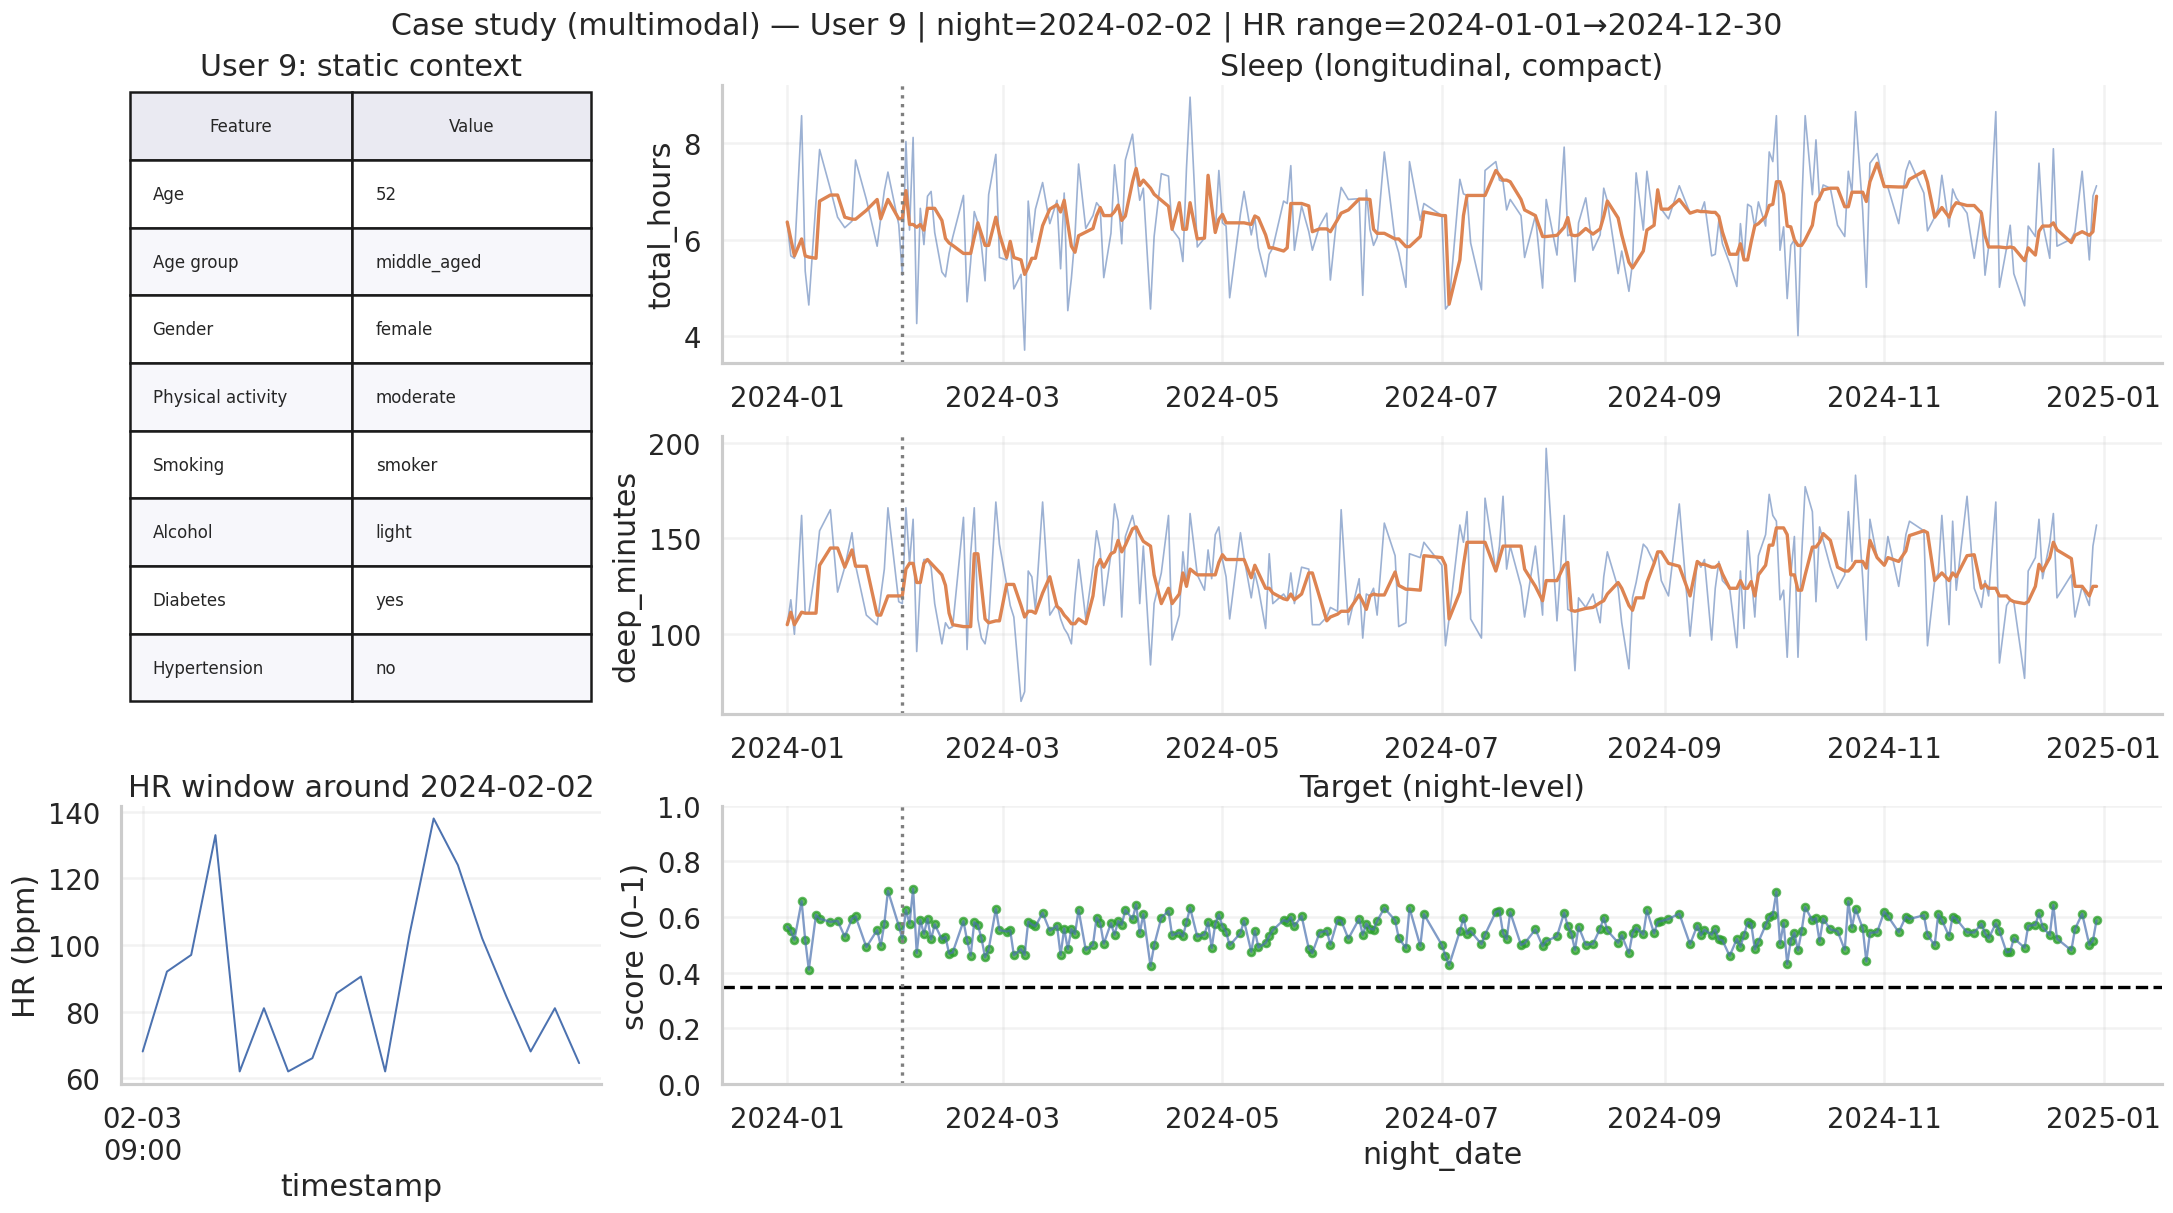

In [8]:
# ==========================================
# Multimodal Case Study Visualizer
# Sleep (night-level) + HR (minute-level) + Context (tabular)
# Robust alignment: pick user + night with HR overlap
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from matplotlib.dates import DateFormatter
from matplotlib.table import Table


# CONFIG
CONFIG = {
    "PATH_SLEEP": "Synthetic-data/outputs/300/sleep_series.csv",
    "PATH_PROF": "Synthetic-data/outputs/300/user_profiles.csv",
    "PATH_LAB": "Synthetic-data/outputs/300/nightly_labeled.csv",
    "PATH_SCORE": "Synthetic-data/outputs/300/scored_labeled.csv",
    "PATH_HR": "Synthetic-data/outputs/300/hr_series.csv",

    "HR_CHUNKSIZE": 1_000_000,
    "HR_RESAMPLE_RULE": "5min",

    # Night → HR window heuristic (can adjust)
    "NIGHT_WINDOW_START_HOUR": 18,
    "NIGHT_WINDOW_END_HOUR": 12,

    # Selection
    "MIN_NIGHTS": 120,                 # for sleep
    "MIN_HR_ROWS": 2000,               # avoid users with tiny HR
    "MAX_USERS_TO_TRY": 50,            # to find overlap efficiently

    # Output
    "OUTDIR": "figures_case_study",
    "SAVE": True,
}

PALETTE_CLASS = {0: "#d62728", 1: "#2ca02c"}


# Style
def set_plot_style():
    sns.set_theme(style="whitegrid", context="talk")
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

# Utilities
def label_to_int(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, np.integer)):
        return int(x)
    if isinstance(x, (float, np.floating)) and np.isfinite(x):
        return int(x)
    s = str(x).strip().lower()
    if "adequate" in s:
        return 1
    if "deficient" in s:
        return 0
    return np.nan

def safe_to_datetime(s):
    return pd.to_datetime(s, errors="coerce", utc=False)

def night_to_hr_window(night_date, start_hour=18, end_hour=12):
    night_date = pd.to_datetime(night_date).normalize()
    start_ts = night_date + pd.Timedelta(hours=start_hour)
    end_ts = night_date + pd.Timedelta(days=1, hours=end_hour)
    return start_ts, end_ts

def ensure_outdir(path):
    os.makedirs(path, exist_ok=True)


# Load night-level dataset
def load_night_level(path_sleep, path_prof, path_lab, path_score):
    sleep = pd.read_csv(path_sleep, parse_dates=["night_date"])
    prof  = pd.read_csv(path_prof)
    lab   = pd.read_csv(path_lab, parse_dates=["night_date"])
    score = pd.read_csv(path_score, parse_dates=["night_date"])

    df = sleep.merge(
        score[["user_id", "night_date", "recovery_score_0_1"]],
        on=["user_id", "night_date"], how="left"
    ).merge(
        lab[["user_id", "night_date", "recovery_threshold", "recovery_label_binary"]],
        on=["user_id", "night_date"], how="left"
    )

    df["y"] = df["recovery_label_binary"].apply(label_to_int)
    df = df.sort_values(["user_id", "night_date"]).reset_index(drop=True)
    return df, prof


# HR: coverage (chunked)
def hr_user_coverage(path_hr, chunksize=1_000_000, cache_path=None):
    """
    Returns df: user_id, rows, min_ts, max_ts
    """
    if cache_path and os.path.exists(cache_path):
        cov = pd.read_csv(cache_path, parse_dates=["min_ts", "max_ts"])
        return cov.sort_values("rows", ascending=False).reset_index(drop=True)

    agg = {}  # user -> [count, min_ts, max_ts]
    total_rows = 0

    for chunk in pd.read_csv(path_hr, chunksize=chunksize):
        total_rows += len(chunk)
        if "user_id" not in chunk.columns or "timestamp" not in chunk.columns:
            raise ValueError("hr_series.csv must have columns: user_id, timestamp")

        ts = safe_to_datetime(chunk["timestamp"])
        chunk = chunk.assign(_ts=ts).dropna(subset=["_ts"])

        g = chunk.groupby("user_id")["_ts"].agg(["count", "min", "max"]).reset_index()
        for _, r in g.iterrows():
            uid = int(r["user_id"])
            c = int(r["count"])
            mn = r["min"]
            mx = r["max"]
            if uid not in agg:
                agg[uid] = [c, mn, mx]
            else:
                agg[uid][0] += c
                agg[uid][1] = min(agg[uid][1], mn)
                agg[uid][2] = max(agg[uid][2], mx)

    cov = pd.DataFrame([{
        "user_id": k,
        "rows": v[0],
        "min_ts": v[1],
        "max_ts": v[2],
    } for k, v in agg.items()]).sort_values("rows", ascending=False).reset_index(drop=True)

    if cache_path:
        cov.to_csv(cache_path, index=False)

    return cov


# HR: load window (chunked)
def load_hr_window(path_hr, user_id, start_ts, end_ts, chunksize=1_000_000):
    out = []
    start_ts = pd.to_datetime(start_ts)
    end_ts = pd.to_datetime(end_ts)

    for chunk in pd.read_csv(path_hr, chunksize=chunksize):
        chunk = chunk[chunk["user_id"] == user_id].copy()
        if len(chunk) == 0:
            continue

        chunk["timestamp"] = safe_to_datetime(chunk["timestamp"])
        chunk = chunk.dropna(subset=["timestamp"])
        chunk = chunk[(chunk["timestamp"] >= start_ts) & (chunk["timestamp"] <= end_ts)]
        if len(chunk) > 0:
            out.append(chunk)

    if len(out) == 0:
        return pd.DataFrame(columns=["user_id", "timestamp", "hr", "state"])

    hr = pd.concat(out, ignore_index=True).sort_values("timestamp")
    hr["hr"] = pd.to_numeric(hr["hr"], errors="coerce")
    hr = hr.dropna(subset=["hr"])
    return hr


# Pick user with overlap (sleep ∩ HR)
def pick_multimodal_user(df_sleep, hr_cov, min_nights=120, min_hr_rows=2000, max_users_to_try=50):
    sleep_counts = df_sleep.groupby("user_id")["night_date"].count().sort_values(ascending=False)
    sleep_candidates = sleep_counts[sleep_counts >= min_nights].index.astype(int).tolist()

    hr_good = hr_cov[hr_cov["rows"] >= min_hr_rows].copy()
    hr_good["user_id"] = hr_good["user_id"].astype(int)

    hr_candidates = hr_good["user_id"].tolist()

    # Try intersection first
    inter = [u for u in sleep_candidates if u in set(hr_candidates)]
    if inter:
        # Choose the one with most HR rows among intersection
        sub = hr_good[hr_good["user_id"].isin(inter)].sort_values("rows", ascending=False)
        return int(sub.iloc[0]["user_id"])

    # Otherwise fallback: best HR user (but warn in prints)
    return int(hr_good.iloc[0]["user_id"])


# Pick a night_date that intersects HR range
def pick_best_night_by_hr_density(path_hr, user_id, u_sleep,
                                 start_hour=18, end_hour=12,
                                 chunksize=1_000_000,
                                 sample_nights=40, min_points=200):
    """
    Picks the night_date whose HR window contains the most HR points.
    Falls back to any overlapping night if none reach min_points.
    """
    nights = pd.to_datetime(u_sleep["night_date"].dropna().unique())
    nights = np.sort(nights)

    if len(nights) == 0:
        return None

    # sample nights evenly across the year to avoid scanning too many
    if len(nights) > sample_nights:
        idx = np.linspace(0, len(nights)-1, sample_nights).round().astype(int)
        nights_to_try = nights[idx]
    else:
        nights_to_try = nights

    best = (None, -1)  # (night_date, count)

    for nd in nights_to_try:
        start_ts, end_ts = night_to_hr_window(nd, start_hour=start_hour, end_hour=end_hour)
        hrw = load_hr_window(path_hr, user_id, start_ts, end_ts, chunksize=chunksize)
        c = len(hrw)
        if c > best[1]:
            best = (nd, c)
        if c >= min_points:
            # early stop: we already found a window that is good enough for plotting
            return nd

    # If none reach min_points, return the best we found (may be 0)
    return best[0]


# Plot: context table
def plot_profile_table(ax, prof_row: pd.Series, title):
    ax.axis("off")
    ax.set_title(title)

    rows = [
        ("Age", prof_row.get("age")),
        ("Age group", prof_row.get("age_group")),
        ("Gender", prof_row.get("gender")),
        ("Physical activity", prof_row.get("physical_activity_level")),
        ("Smoking", prof_row.get("smoking_status")),
        ("Alcohol", prof_row.get("alcohol_consumption")),
        ("Diabetes", prof_row.get("diabetes")),
        ("Hypertension", prof_row.get("hypertension")),
    ]

    table = Table(ax, bbox=[0.02, 0.02, 0.96, 0.86])
    col_w = [0.48, 0.52]

    table.add_cell(-1, 0, width=col_w[0], height=0.08, text="Feature", loc="center", facecolor="#EAEAF2")
    table.add_cell(-1, 1, width=col_w[1], height=0.08, text="Value", loc="center", facecolor="#EAEAF2")

    for i, (k, v) in enumerate(rows):
        face = "#FFFFFF" if i % 2 == 0 else "#F7F7FB"
        table.add_cell(i, 0, width=col_w[0], height=0.08, text=str(k), loc="left", facecolor=face)
        table.add_cell(i, 1, width=col_w[1], height=0.08, text=str(v), loc="left", facecolor=face)

    ax.add_table(table)


# Plot: sleep + score
def plot_sleep_multivariate(axs, u, vars_to_plot, rolling_days=7):
    for ax, col in zip(axs, vars_to_plot):
        ax.plot(u["night_date"], u[col], linewidth=1.0, alpha=0.55, color="#4c72b0")
        trend = u.set_index("night_date")[col].rolling(f"{rolling_days}D").median()
        ax.plot(trend.index, trend.values, linewidth=2.0, color="#dd8452", alpha=0.95)
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.25)

    axs[-1].set_xlabel("night_date")
    axs[0].xaxis.set_major_formatter(DateFormatter("%Y-%m"))

def plot_score(ax, u):
    ax.plot(u["night_date"], u["recovery_score_0_1"], linewidth=1.4, color="#4c72b0", alpha=0.70, label="recovery_score_0_1")
    thr = np.nanmedian(u["recovery_threshold"].values)
    if np.isfinite(thr):
        ax.axhline(thr, color="black", linestyle="--", linewidth=2, label=f"threshold ≈ {thr:.3f}")

    uu = u.dropna(subset=["y"]).copy()
    if len(uu) > 0:
        uu["y"] = uu["y"].astype(int)
        for yval, g in uu.groupby("y"):
            ax.scatter(g["night_date"], g["recovery_score_0_1"], s=18, color=PALETTE_CLASS[int(yval)], alpha=0.75)

    ax.set_ylim(0, 1)
    ax.set_title("Recovery score vs threshold")
    ax.set_xlabel("night_date")
    ax.set_ylabel("score (0–1)")
    ax.grid(True, alpha=0.25)

# Plot: HR window
def plot_hr(ax, hr, title, resample_rule="5min"):
    if hr.empty:
        ax.axis("off")
        ax.set_title(title)
        ax.text(0.02, 0.55, "No HR data in this window.\n(Alignment succeeded but window is empty.)", fontsize=12)
        return

    hr = hr.copy().sort_values("timestamp")
    hr = hr.set_index("timestamp")
    hr_res = hr["hr"].resample(resample_rule).median()

    ax.plot(hr_res.index, hr_res.values, color="#4c72b0", linewidth=1.2)
    ax.set_title(title)
    ax.set_xlabel("timestamp")
    ax.set_ylabel("HR (bpm)")
    ax.grid(True, alpha=0.25)
    #ax.xaxis.set_major_formatter(DateFormatter("%m-%d\n%H:%M"))


    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))      # cada 2 horas
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        label.set_ha("center")



# Composite figure: case study
def make_case_study_figure(df_sleep, prof, hr_cov, path_hr, user_id, night_date, outpath=None):
    u = df_sleep[df_sleep["user_id"] == user_id].copy()
    prof_row = prof[prof["user_id"] == user_id].iloc[0]
    cov_row = hr_cov[hr_cov["user_id"].astype(int) == int(user_id)].iloc[0]

    # HR window aligned to chosen night
    start_ts, end_ts = night_to_hr_window(
        night_date,
        start_hour=CONFIG["NIGHT_WINDOW_START_HOUR"],
        end_hour=CONFIG["NIGHT_WINDOW_END_HOUR"]
    )
    hrw = load_hr_window(path_hr, user_id, start_ts, end_ts, chunksize=CONFIG["HR_CHUNKSIZE"])

    # ---- Figure layout ----
    fig = plt.figure(figsize=(18, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 4)

    # Left column: context table
    ax_ctx = fig.add_subplot(gs[0:2, 0])
    plot_profile_table(
        ax_ctx, prof_row,
        title=f"User {user_id}: static context"
    )

    # Top-right: sleep multivariate (3 subplots)
    vars_to_plot = ["total_hours", "deep_minutes", "rem_minutes"]
    ax_s1 = fig.add_subplot(gs[0, 1:4])
    ax_s2 = fig.add_subplot(gs[1, 1:4], sharex=ax_s1)
    ax_s3 = fig.add_subplot(gs[2, 1:4], sharex=ax_s1)  # will be score + HR overlay? We'll split below.

    # Plot sleep (compact)
    ax_s1.plot(u["night_date"], u["total_hours"], linewidth=1.0, alpha=0.55, color="#4c72b0")
    ax_s1.plot(u.set_index("night_date")["total_hours"].rolling("7D").median(), linewidth=2.0, color="#dd8452")
    ax_s1.set_ylabel("total_hours")
    ax_s1.set_title("Sleep (longitudinal, compact)")
    ax_s1.grid(True, alpha=0.25)

    ax_s2.plot(u["night_date"], u["deep_minutes"], linewidth=1.0, alpha=0.55, color="#4c72b0")
    ax_s2.plot(u.set_index("night_date")["deep_minutes"].rolling("7D").median(), linewidth=2.0, color="#dd8452")
    ax_s2.set_ylabel("deep_minutes")
    ax_s2.grid(True, alpha=0.25)

    # Score on ax_s3
    plot_score(ax_s3, u)
    ax_s3.set_title("Target (night-level)")

    # Mark chosen night
    for ax in [ax_s1, ax_s2, ax_s3]:
        ax.axvline(pd.to_datetime(night_date), color="#7f7f7f", linestyle=":", linewidth=2)

    # HR as inset-like: create a new axis below context (bottom-left) spanning 1 row
    ax_hr = fig.add_subplot(gs[2, 0])
    plot_hr(
        ax_hr, hrw,
        title=f"HR window around {pd.to_datetime(night_date).date()}",
        resample_rule=CONFIG["HR_RESAMPLE_RULE"]
    )

    # Global title with ranges
    fig.suptitle(
        f"Case study (multimodal) — User {user_id} | night={pd.to_datetime(night_date).date()} | "
        f"HR range={pd.to_datetime(cov_row['min_ts']).date()}→{pd.to_datetime(cov_row['max_ts']).date()}",
        fontsize=18
    )

    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    return fig


# MAIN
def main():
    set_plot_style()
    ensure_outdir(CONFIG["OUTDIR"])

    # Load sleep-level merged dataset
    df_sleep, prof = load_night_level(CONFIG["PATH_SLEEP"], CONFIG["PATH_PROF"], CONFIG["PATH_LAB"], CONFIG["PATH_SCORE"])

    # HR coverage (cache recommended)
    cov_cache = os.path.join(CONFIG["OUTDIR"], "hr_user_coverage.csv")
    hr_cov = hr_user_coverage(CONFIG["PATH_HR"], chunksize=CONFIG["HR_CHUNKSIZE"], cache_path=cov_cache)
    hr_cov["user_id"] = hr_cov["user_id"].astype(int)

    # Pick a multimodal user
    user_id = pick_multimodal_user(
        df_sleep, hr_cov,
        min_nights=CONFIG["MIN_NIGHTS"],
        min_hr_rows=CONFIG["MIN_HR_ROWS"],
        max_users_to_try=CONFIG["MAX_USERS_TO_TRY"],
    )

    # Pick a night that overlaps HR timestamps for that user
    u = df_sleep[df_sleep["user_id"] == user_id].copy()
    cov_row = hr_cov[hr_cov["user_id"] == user_id].iloc[0]
    night_date = pick_best_night_by_hr_density(
    CONFIG["PATH_HR"], user_id, u,
    start_hour=CONFIG["NIGHT_WINDOW_START_HOUR"],
    end_hour=CONFIG["NIGHT_WINDOW_END_HOUR"],
    chunksize=CONFIG["HR_CHUNKSIZE"],
    sample_nights=40,
    min_points=200
    )

    print("Chosen multimodal user:", user_id, "| nights:", len(u))
    print("HR rows:", int(cov_row["rows"]), "| HR range:", cov_row["min_ts"], "→", cov_row["max_ts"])
    print("Chosen night_date with HR overlap:", night_date)

    if night_date is None:
        raise RuntimeError("No overlapping night_date found for this user. Try relaxing window hours or selecting different user.")

    outpath = os.path.join(CONFIG["OUTDIR"], f"case_study_user_{user_id}_night_{pd.to_datetime(night_date).date()}.png")
    fig = make_case_study_figure(df_sleep, prof, hr_cov, CONFIG["PATH_HR"], user_id, night_date, outpath if CONFIG["SAVE"] else None)

    plt.show()

if __name__ == "__main__":
    main()

Chosen multimodal user: 9 | nights: 247
HR rows: 31919 | HR range: 2024-01-01 05:07:37.714454101 → 2024-12-30 11:50:11.816256548
Chosen night_date: 2024-04-22T00:00:00.000000000


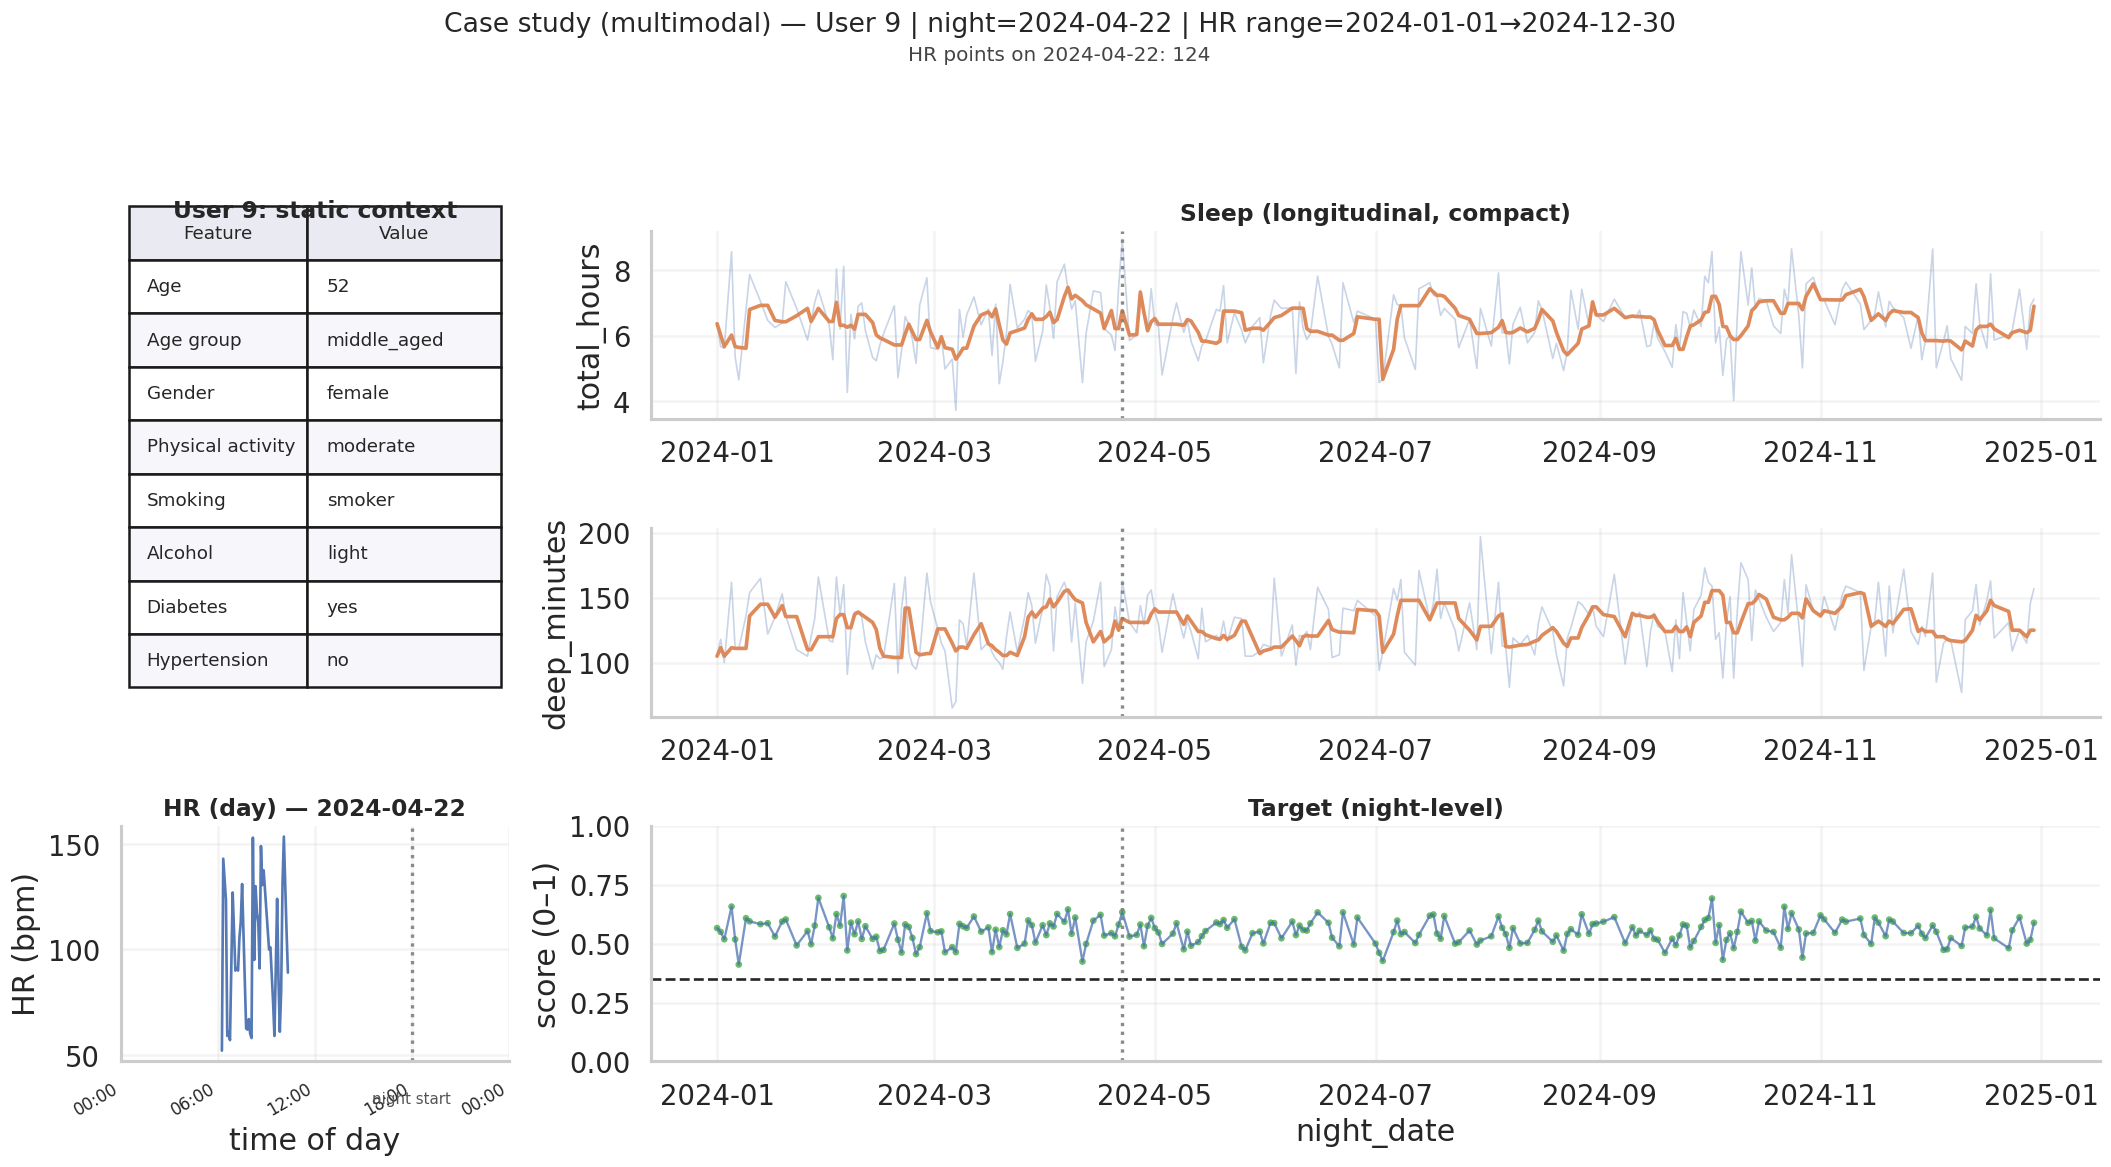

In [2]:
# ==========================================
# Multimodal Case Study Visualizer
# Sleep (night-level) + HR (minute-level) aligned by DAY of selected night_date
#
# Key change:
#   If night_date == 2024-02-02, HR panel shows HR for that day:
#     2024-02-02 00:00:00  ->  2024-02-03 00:00:00 (exclusive)
#
# Layout fixes:
#  - reserved top margin for title/subtitle
#  - controlled tick density and formatting (no overlaps)
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.table import Table


# -------------------------
# CONFIG
# -------------------------
CONFIG = {
    "PATH_SLEEP": "Synthetic-data/outputs/300/sleep_series.csv",
    "PATH_PROF": "Synthetic-data/outputs/300/user_profiles.csv",
    "PATH_LAB": "Synthetic-data/outputs/300/nightly_labeled.csv",
    "PATH_SCORE": "Synthetic-data/outputs/300/scored_labeled.csv",
    "PATH_HR": "Synthetic-data/outputs/300/hr_series.csv",

    "HR_CHUNKSIZE": 1_000_000,

    # HR display options
    "HR_RESAMPLE_RULE": "5min",     # for plotting smooth curve; set None to disable
    "HR_DAY_TICK_HOURS": 6,         # x ticks every N hours (4 or 6 work well)
    "HR_YLIM": None,               # e.g. (40, 160) or None

    # Night window heuristic (only for markers, not for HR range)
    "NIGHT_WINDOW_START_HOUR": 18,
    "NIGHT_WINDOW_END_HOUR": 12,

    # Selection
    "MIN_NIGHTS": 120,
    "MIN_HR_ROWS": 2000,

    # Night selection by HR density (measured in *day window* now)
    "SAMPLE_NIGHTS": 40,
    "MIN_HR_POINTS_IN_DAY": 200,

    # Output
    "OUTDIR": "figures_case_study",
    "SAVE": True,
}

PALETTE_CLASS = {0: "#d62728", 1: "#2ca02c"}
CURSOR_KW = dict(color="#7f7f7f", linestyle=":", linewidth=2, alpha=0.9)


# -------------------------
# Style
# -------------------------
def set_plot_style():
    sns.set_theme(style="whitegrid", context="talk")
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titleweight": "semibold",
        "font.family": "DejaVu Sans",
    })


# -------------------------
# Utilities
# -------------------------
def label_to_int(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, np.integer)):
        return int(x)
    if isinstance(x, (float, np.floating)) and np.isfinite(x):
        return int(x)
    s = str(x).strip().lower()
    if "adequate" in s:
        return 1
    if "deficient" in s:
        return 0
    return np.nan

def safe_to_datetime(s):
    # Keep naive timestamps for matplotlib stability
    return pd.to_datetime(s, errors="coerce")

def ensure_outdir(path):
    os.makedirs(path, exist_ok=True)

def day_window_for_night(night_date):
    """
    For night_date = 2024-02-02, return the HR day window:
      [2024-02-02 00:00:00, 2024-02-03 00:00:00)
    """
    d0 = pd.to_datetime(night_date).normalize()
    d1 = d0 + pd.Timedelta(days=1)
    return d0, d1

def night_window_for_markers(night_date, start_hour=18, end_hour=12):
    """
    Optional markers for the 'night' concept.
    Start at night_date 18:00, end at next day 12:00.
    """
    nd = pd.to_datetime(night_date).normalize()
    start_ts = nd + pd.Timedelta(hours=start_hour)
    end_ts = nd + pd.Timedelta(days=1, hours=end_hour)
    return start_ts, end_ts


# -------------------------
# Load night-level dataset
# -------------------------
def load_night_level(path_sleep, path_prof, path_lab, path_score):
    sleep = pd.read_csv(path_sleep, parse_dates=["night_date"])
    prof  = pd.read_csv(path_prof)
    lab   = pd.read_csv(path_lab, parse_dates=["night_date"])
    score = pd.read_csv(path_score, parse_dates=["night_date"])

    df = sleep.merge(
        score[["user_id", "night_date", "recovery_score_0_1"]],
        on=["user_id", "night_date"], how="left"
    ).merge(
        lab[["user_id", "night_date", "recovery_threshold", "recovery_label_binary"]],
        on=["user_id", "night_date"], how="left"
    )

    df["y"] = df["recovery_label_binary"].apply(label_to_int)
    df = df.sort_values(["user_id", "night_date"]).reset_index(drop=True)
    return df, prof


# -------------------------
# HR: coverage (chunked)
# -------------------------
def hr_user_coverage(path_hr, chunksize=1_000_000, cache_path=None):
    if cache_path and os.path.exists(cache_path):
        cov = pd.read_csv(cache_path, parse_dates=["min_ts", "max_ts"])
        return cov.sort_values("rows", ascending=False).reset_index(drop=True)

    agg = {}  # user -> [count, min_ts, max_ts]
    for chunk in pd.read_csv(path_hr, chunksize=chunksize):
        if "user_id" not in chunk.columns or "timestamp" not in chunk.columns:
            raise ValueError("hr_series.csv must have columns: user_id, timestamp")

        ts = safe_to_datetime(chunk["timestamp"])
        chunk = chunk.assign(_ts=ts).dropna(subset=["_ts"])

        g = chunk.groupby("user_id")["_ts"].agg(["count", "min", "max"]).reset_index()
        for _, r in g.iterrows():
            uid = int(r["user_id"])
            c = int(r["count"])
            mn = r["min"]
            mx = r["max"]
            if uid not in agg:
                agg[uid] = [c, mn, mx]
            else:
                agg[uid][0] += c
                agg[uid][1] = min(agg[uid][1], mn)
                agg[uid][2] = max(agg[uid][2], mx)

    cov = pd.DataFrame([{
        "user_id": k,
        "rows": v[0],
        "min_ts": v[1],
        "max_ts": v[2],
    } for k, v in agg.items()]).sort_values("rows", ascending=False).reset_index(drop=True)

    if cache_path:
        cov.to_csv(cache_path, index=False)

    return cov


# -------------------------
# HR: load window (chunked)
# -------------------------
def load_hr_window(path_hr, user_id, start_ts, end_ts, chunksize=1_000_000):
    """
    Loads HR in [start_ts, end_ts). End is exclusive to make day windows clean.
    """
    out = []
    start_ts = pd.to_datetime(start_ts)
    end_ts = pd.to_datetime(end_ts)

    for chunk in pd.read_csv(path_hr, chunksize=chunksize):
        chunk = chunk[chunk["user_id"] == user_id].copy()
        if len(chunk) == 0:
            continue

        chunk["timestamp"] = safe_to_datetime(chunk["timestamp"])
        chunk = chunk.dropna(subset=["timestamp"])

        chunk = chunk[(chunk["timestamp"] >= start_ts) & (chunk["timestamp"] < end_ts)]
        if len(chunk) > 0:
            out.append(chunk)

    if len(out) == 0:
        return pd.DataFrame(columns=["user_id", "timestamp", "hr", "state"])

    hr = pd.concat(out, ignore_index=True).sort_values("timestamp")
    hr["hr"] = pd.to_numeric(hr["hr"], errors="coerce")
    hr = hr.dropna(subset=["hr"])
    return hr


# -------------------------
# Pick user with overlap (sleep ∩ HR)
# -------------------------
def pick_multimodal_user(df_sleep, hr_cov, min_nights=120, min_hr_rows=2000):
    sleep_counts = df_sleep.groupby("user_id")["night_date"].count().sort_values(ascending=False)
    sleep_candidates = sleep_counts[sleep_counts >= min_nights].index.astype(int).tolist()

    hr_good = hr_cov[hr_cov["rows"] >= min_hr_rows].copy()
    hr_good["user_id"] = hr_good["user_id"].astype(int)

    inter = [u for u in sleep_candidates if u in set(hr_good["user_id"].tolist())]
    if inter:
        sub = hr_good[hr_good["user_id"].isin(inter)].sort_values("rows", ascending=False)
        return int(sub.iloc[0]["user_id"])

    return int(hr_good.iloc[0]["user_id"])


# -------------------------
# Pick night by HR density (DAY window!)
# -------------------------
def pick_best_night_by_hr_day_density(path_hr, user_id, u_sleep,
                                     chunksize=1_000_000,
                                     sample_nights=40, min_points=200):
    nights = pd.to_datetime(u_sleep["night_date"].dropna().unique())
    nights = np.sort(nights)
    if len(nights) == 0:
        return None

    if len(nights) > sample_nights:
        idx = np.linspace(0, len(nights)-1, sample_nights).round().astype(int)
        nights_to_try = nights[idx]
    else:
        nights_to_try = nights

    best = (None, -1)
    for nd in nights_to_try:
        d0, d1 = day_window_for_night(nd)
        hrw = load_hr_window(path_hr, user_id, d0, d1, chunksize=chunksize)
        c = len(hrw)
        if c > best[1]:
            best = (nd, c)
        if c >= min_points:
            return nd

    return best[0]


# -------------------------
# Plot: context table
# -------------------------
def plot_profile_table(ax, prof_row: pd.Series, title):
    ax.axis("off")
    ax.set_title(title, pad=8, fontsize=14)

    rows = [
        ("Age", prof_row.get("age")),
        ("Age group", prof_row.get("age_group")),
        ("Gender", prof_row.get("gender")),
        ("Physical activity", prof_row.get("physical_activity_level")),
        ("Smoking", prof_row.get("smoking_status")),
        ("Alcohol", prof_row.get("alcohol_consumption")),
        ("Diabetes", prof_row.get("diabetes")),
        ("Hypertension", prof_row.get("hypertension")),
    ]

    table = Table(ax, bbox=[0.02, 0.06, 0.96, 0.88])
    col_w = [0.48, 0.52]
    header_face = "#EAEAF2"

    table.add_cell(-1, 0, width=col_w[0], height=0.08, text="Feature", loc="center", facecolor=header_face)
    table.add_cell(-1, 1, width=col_w[1], height=0.08, text="Value",   loc="center", facecolor=header_face)

    for i, (k, v) in enumerate(rows):
        face = "#FFFFFF" if i % 2 == 0 else "#F7F7FB"
        table.add_cell(i, 0, width=col_w[0], height=0.08, text=str(k), loc="left", facecolor=face)
        table.add_cell(i, 1, width=col_w[1], height=0.08, text=str(v), loc="left", facecolor=face)

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    ax.add_table(table)


# -------------------------
# Plot: score
# -------------------------
def plot_score(ax, u):
    ax.plot(u["night_date"], u["recovery_score_0_1"], linewidth=1.4, color="#4c72b0", alpha=0.75)

    thr = np.nanmedian(u["recovery_threshold"].values)
    if np.isfinite(thr):
        ax.axhline(thr, color="black", linestyle="--", linewidth=1.6, alpha=0.85)

    uu = u.dropna(subset=["y"]).copy()
    if len(uu) > 0:
        uu["y"] = uu["y"].astype(int)
        for yval, g in uu.groupby("y"):
            ax.scatter(g["night_date"], g["recovery_score_0_1"],
                       s=16, color=PALETTE_CLASS[int(yval)], alpha=0.70, edgecolor="none")

    ax.set_ylim(0, 1)
    ax.set_title("Target (night-level)", pad=6, fontsize=14)
    ax.set_xlabel("night_date")
    ax.set_ylabel("score (0–1)")
    ax.grid(True, alpha=0.22)


# -------------------------
# Plot: HR day (readable hours)
# -------------------------
def plot_hr_day(ax, hr, day_date, resample_rule="5min",
                tick_hours=6, ylim=None,
                night_marker_start_hour=18, show_night_marker=True):
    day_date = pd.to_datetime(day_date).normalize()
    d0, d1 = day_window_for_night(day_date)

    ax.set_title(f"HR (day) — {day_date.date()}", pad=6, fontsize=14)
    ax.set_xlabel("time of day")
    ax.set_ylabel("HR (bpm)")
    ax.grid(True, alpha=0.22)

    # x-limits locked to the day, so labels are stable and readable
    ax.set_xlim(d0, d1)

    if hr.empty:
        ax.text(0.02, 0.55, "No HR data for this day.", fontsize=12, transform=ax.transAxes)
        return

    hr = hr.copy().sort_values("timestamp")

    if resample_rule:
        s = hr.set_index("timestamp")["hr"].resample(resample_rule).median().dropna()
        ax.plot(s.index, s.values, color="#4c72b0", linewidth=1.6, alpha=0.95)
    else:
        ax.plot(hr["timestamp"], hr["hr"], color="#4c72b0", linewidth=1.1, alpha=0.8)

    # Optional marker: "night start" inside the day (e.g., 18:00)
    if show_night_marker:
        night_start = day_date + pd.Timedelta(hours=night_marker_start_hour)
        ax.axvline(night_start, **CURSOR_KW)
        ax.annotate(
            "night start",
            xy=(night_start, ax.get_ylim()[0]),
            xytext=(0, -18),
            textcoords="offset points",
            ha="center",
            va="top",
            fontsize=9,
            color="#555555"
        )

    # Y range (optional)
    if ylim is not None:
        ax.set_ylim(*ylim)

    # Hour ticks: every N hours, formatted as HH:MM (no date clutter)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=int(tick_hours)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    ax.tick_params(axis="x", labelsize=10, pad=2)
    for lab in ax.get_xticklabels():
        lab.set_rotation(30)
        lab.set_ha("right")


# -------------------------
# Composite figure
# -------------------------
def make_case_study_figure(df_sleep, prof, hr_cov, path_hr, user_id, night_date, outpath=None):
    u = df_sleep[df_sleep["user_id"] == user_id].copy()
    prof_row = prof[prof["user_id"] == user_id].iloc[0]
    cov_row = hr_cov[hr_cov["user_id"].astype(int) == int(user_id)].iloc[0]

    # HR day for selected night_date
    d0, d1 = day_window_for_night(night_date)
    hr_day = load_hr_window(path_hr, user_id, d0, d1, chunksize=CONFIG["HR_CHUNKSIZE"])

    # Layout: bottom row slightly taller to keep HR ticks clean
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 4, height_ratios=[1.0, 1.0, 1.25])

    ax_ctx = fig.add_subplot(gs[0:2, 0])
    ax_hr  = fig.add_subplot(gs[2, 0])

    ax_s1  = fig.add_subplot(gs[0, 1:4])
    ax_s2  = fig.add_subplot(gs[1, 1:4], sharex=ax_s1)
    ax_s3  = fig.add_subplot(gs[2, 1:4], sharex=ax_s1)

    # Context
    plot_profile_table(ax_ctx, prof_row, title=f"User {user_id}: static context")

    # Sleep plots (clean)
    series_color = "#4c72b0"
    trend_color  = "#dd8452"

    ax_s1.plot(u["night_date"], u["total_hours"], linewidth=1.0, alpha=0.30, color=series_color)
    ax_s1.plot(u.set_index("night_date")["total_hours"].rolling("7D").median(),
               linewidth=2.2, alpha=0.95, color=trend_color)
    ax_s1.set_ylabel("total_hours")
    ax_s1.set_title("Sleep (longitudinal, compact)", pad=6, fontsize=14)
    ax_s1.grid(True, alpha=0.22)

    ax_s2.plot(u["night_date"], u["deep_minutes"], linewidth=1.0, alpha=0.30, color=series_color)
    ax_s2.plot(u.set_index("night_date")["deep_minutes"].rolling("7D").median(),
               linewidth=2.2, alpha=0.95, color=trend_color)
    ax_s2.set_ylabel("deep_minutes")
    ax_s2.grid(True, alpha=0.22)

    plot_score(ax_s3, u)

    # Cursor for chosen night_date across longitudinal panels
    night_dt = pd.to_datetime(night_date)
    for ax in (ax_s1, ax_s2, ax_s3):
        ax.axvline(night_dt, **CURSOR_KW)

    # Longitudinal x-axis ticks: every 2 months, avoid overlap
    locator = mdates.MonthLocator(interval=2)
    formatter = mdates.DateFormatter("%Y-%m")
    ax_s3.xaxis.set_major_locator(locator)
    ax_s3.xaxis.set_major_formatter(formatter)
    for lab in ax_s3.get_xticklabels():
        lab.set_rotation(0)
        lab.set_ha("center")

    # HR (DAY) panel
    plot_hr_day(
        ax_hr,
        hr_day,
        day_date=night_dt,
        resample_rule=CONFIG["HR_RESAMPLE_RULE"],
        tick_hours=CONFIG["HR_DAY_TICK_HOURS"],
        ylim=CONFIG["HR_YLIM"],
        night_marker_start_hour=CONFIG["NIGHT_WINDOW_START_HOUR"],
        show_night_marker=True
    )

    # Global title/subtitle (reserved space)
    hr_points = int(len(hr_day))
    rng_min = pd.to_datetime(cov_row["min_ts"]).date()
    rng_max = pd.to_datetime(cov_row["max_ts"]).date()

    fig.suptitle(
        f"Case study (multimodal) — User {user_id} | night={night_dt.date()} | HR range={rng_min}→{rng_max}",
        fontsize=16, y=0.98
    )
    fig.text(
        0.5, 0.952,
        f"HR points on {night_dt.date()}: {hr_points}",
        ha="center", va="top", fontsize=12, color="#444444"
    )

    fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.90])

    if outpath:
        fig.savefig(outpath, bbox_inches="tight", pad_inches=0.12)

    return fig


# -------------------------
# MAIN
# -------------------------
def main():
    set_plot_style()
    ensure_outdir(CONFIG["OUTDIR"])

    df_sleep, prof = load_night_level(
        CONFIG["PATH_SLEEP"],
        CONFIG["PATH_PROF"],
        CONFIG["PATH_LAB"],
        CONFIG["PATH_SCORE"]
    )

    cov_cache = os.path.join(CONFIG["OUTDIR"], "hr_user_coverage.csv")
    hr_cov = hr_user_coverage(CONFIG["PATH_HR"], chunksize=CONFIG["HR_CHUNKSIZE"], cache_path=cov_cache)
    hr_cov["user_id"] = hr_cov["user_id"].astype(int)

    user_id = pick_multimodal_user(
        df_sleep, hr_cov,
        min_nights=CONFIG["MIN_NIGHTS"],
        min_hr_rows=CONFIG["MIN_HR_ROWS"]
    )

    u = df_sleep[df_sleep["user_id"] == user_id].copy()
    cov_row = hr_cov[hr_cov["user_id"] == user_id].iloc[0]

    # Select night with good HR density in the DAY window
    night_date = pick_best_night_by_hr_day_density(
        CONFIG["PATH_HR"], user_id, u,
        chunksize=CONFIG["HR_CHUNKSIZE"],
        sample_nights=CONFIG["SAMPLE_NIGHTS"],
        min_points=CONFIG["MIN_HR_POINTS_IN_DAY"],
    )

    print("Chosen multimodal user:", user_id, "| nights:", len(u))
    print("HR rows:", int(cov_row["rows"]), "| HR range:", cov_row["min_ts"], "→", cov_row["max_ts"])
    print("Chosen night_date:", night_date)

    if night_date is None:
        raise RuntimeError("No suitable night_date found. Try increasing SAMPLE_NIGHTS or lowering MIN_HR_POINTS_IN_DAY.")

    outpath = os.path.join(
        CONFIG["OUTDIR"],
        f"case_study_user_{user_id}_night_{pd.to_datetime(night_date).date()}_HRday.png"
    )

    make_case_study_figure(
        df_sleep, prof, hr_cov,
        CONFIG["PATH_HR"],
        user_id, night_date,
        outpath if CONFIG["SAVE"] else None
    )

    plt.show()


if __name__ == "__main__":
    main()

Chosen multimodal user: 9 | nights: 247
HR rows: 31919 | HR range: 2024-01-01 05:07:37.714454101 → 2024-12-30 11:50:11.816256548
Chosen night_date: 2024-04-22T00:00:00.000000000


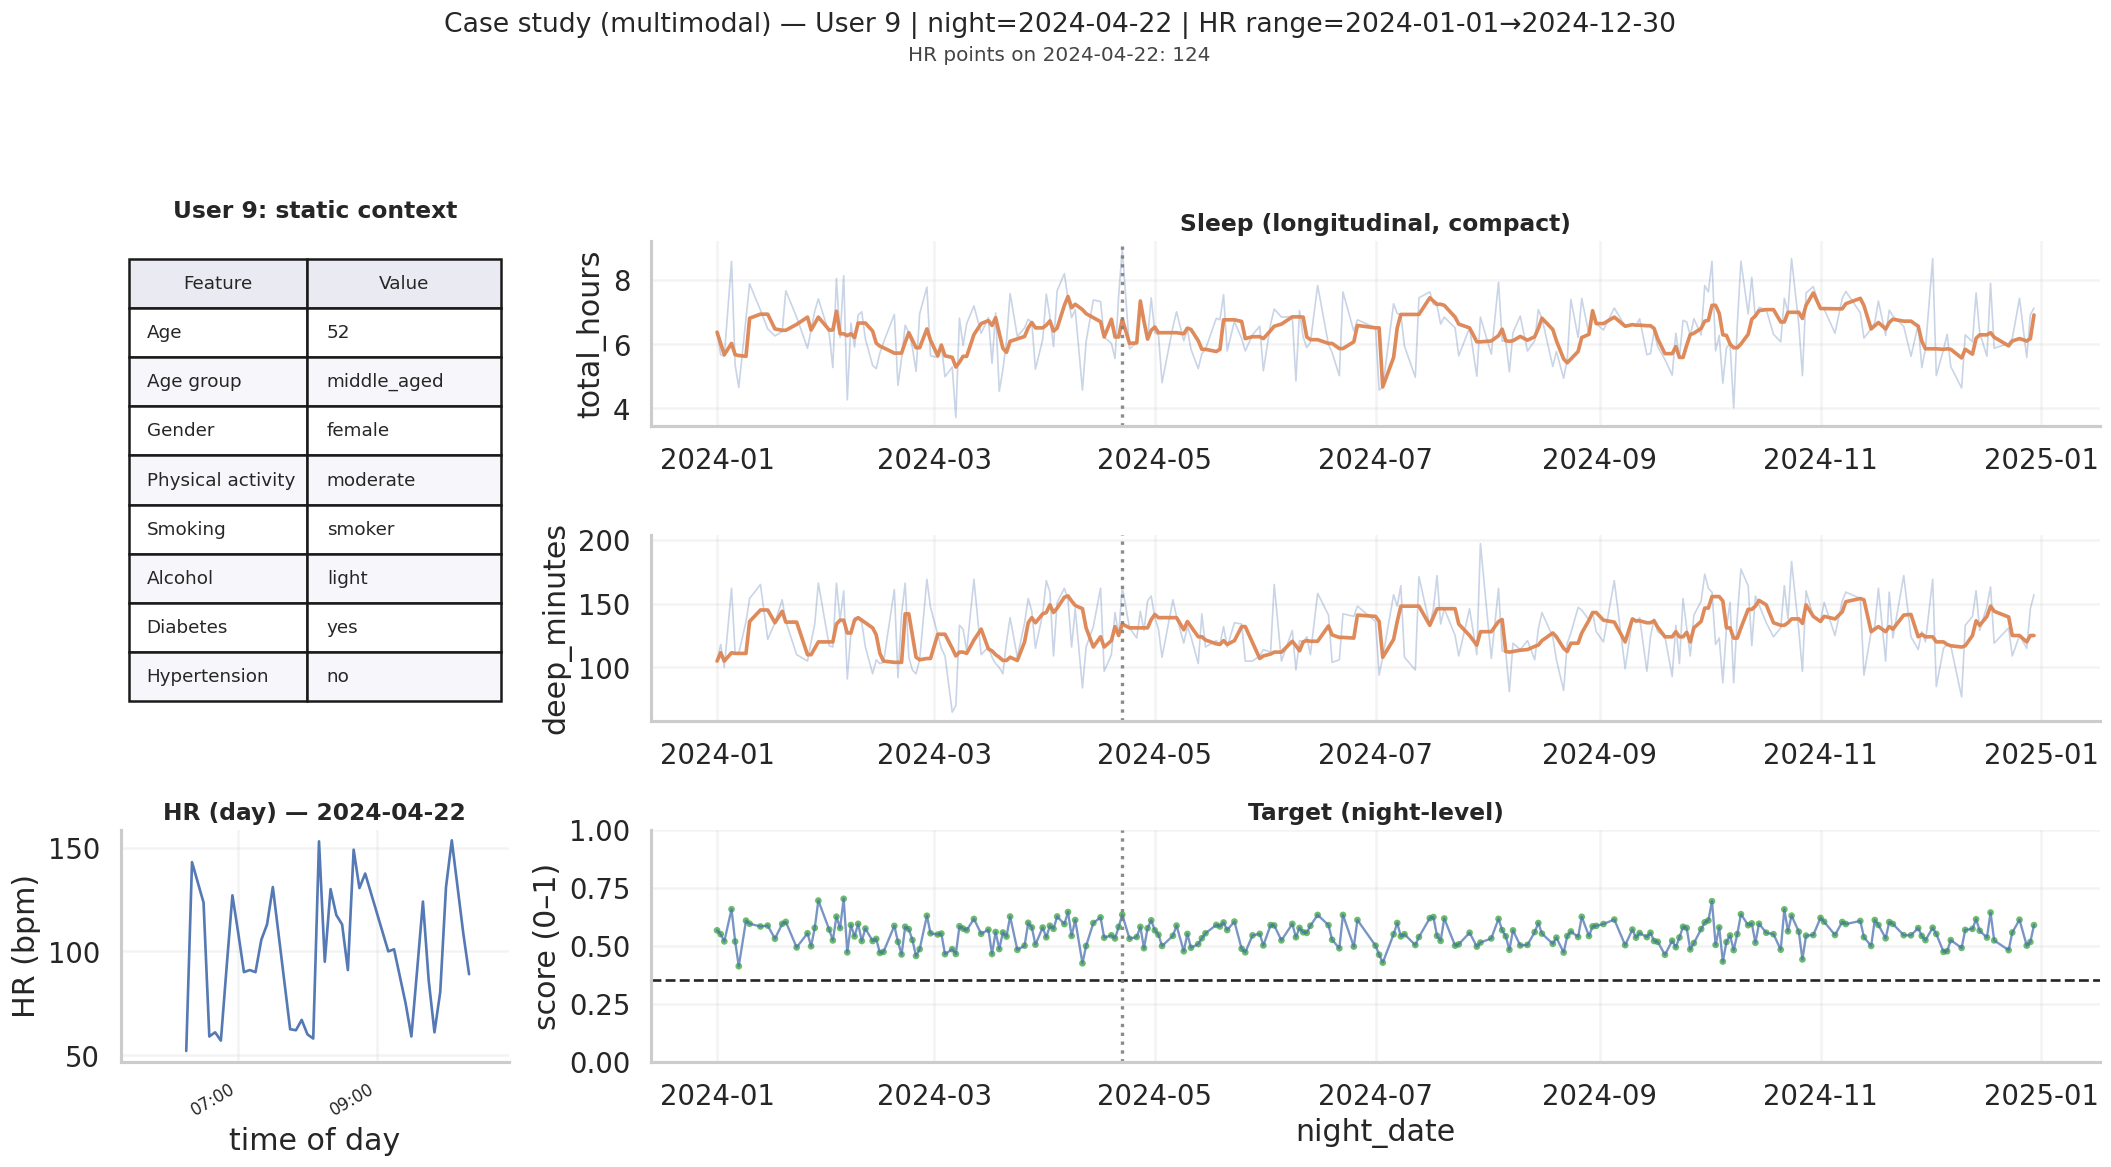

In [3]:
# ==========================================
# Multimodal Case Study Visualizer
# Sleep (night-level) + HR (minute-level) aligned by DAY of selected night_date
#
# HR improvements:
#  - X axis starts ~1h before first HR point (instead of 00:00)
#  - Clean ticks and no overlapping "night start" label
#
# Table improvements:
#  - Title no longer overlaps table header
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.table import Table


# -------------------------
# CONFIG
# -------------------------
CONFIG = {
    "PATH_SLEEP": "Synthetic-data/outputs/300/sleep_series.csv",
    "PATH_PROF": "Synthetic-data/outputs/300/user_profiles.csv",
    "PATH_LAB": "Synthetic-data/outputs/300/nightly_labeled.csv",
    "PATH_SCORE": "Synthetic-data/outputs/300/scored_labeled.csv",
    "PATH_HR": "Synthetic-data/outputs/300/hr_series.csv",

    "HR_CHUNKSIZE": 1_000_000,

    # HR display options
    "HR_RESAMPLE_RULE": "5min",       # smooth curve; set None to plot raw
    "HR_DAY_TICK_HOURS": 2,           # more detailed now that we crop xlim (2–3 works well)
    "HR_XPAD_BEFORE_FIRST": "1h",     # start xlim 1h before first point
    "HR_XPAD_AFTER_LAST": "30min",    # end xlim 30min after last point
    "HR_CLIP_TO_DAY": True,           # keep xlim within the selected day
    "HR_YLIM": None,                  # e.g. (40, 160) or None

    # Night markers (visual cue only)
    "NIGHT_WINDOW_START_HOUR": 18,
    "NIGHT_WINDOW_END_HOUR": 12,

    # Selection
    "MIN_NIGHTS": 120,
    "MIN_HR_ROWS": 2000,

    # Night selection by HR density (measured in *day window*)
    "SAMPLE_NIGHTS": 40,
    "MIN_HR_POINTS_IN_DAY": 200,

    # Output
    "OUTDIR": "figures_case_study",
    "SAVE": True,
}

PALETTE_CLASS = {0: "#d62728", 1: "#2ca02c"}
CURSOR_KW = dict(color="#7f7f7f", linestyle=":", linewidth=2, alpha=0.9)


# -------------------------
# Style
# -------------------------
def set_plot_style():
    sns.set_theme(style="whitegrid", context="talk")
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titleweight": "semibold",
        "font.family": "DejaVu Sans",
    })


# -------------------------
# Utilities
# -------------------------
def label_to_int(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, np.integer)):
        return int(x)
    if isinstance(x, (float, np.floating)) and np.isfinite(x):
        return int(x)
    s = str(x).strip().lower()
    if "adequate" in s:
        return 1
    if "deficient" in s:
        return 0
    return np.nan

def safe_to_datetime(s):
    return pd.to_datetime(s, errors="coerce")

def ensure_outdir(path):
    os.makedirs(path, exist_ok=True)

def day_window_for_night(night_date):
    d0 = pd.to_datetime(night_date).normalize()
    d1 = d0 + pd.Timedelta(days=1)
    return d0, d1


# -------------------------
# Load night-level dataset
# -------------------------
def load_night_level(path_sleep, path_prof, path_lab, path_score):
    sleep = pd.read_csv(path_sleep, parse_dates=["night_date"])
    prof  = pd.read_csv(path_prof)
    lab   = pd.read_csv(path_lab, parse_dates=["night_date"])
    score = pd.read_csv(path_score, parse_dates=["night_date"])

    df = sleep.merge(
        score[["user_id", "night_date", "recovery_score_0_1"]],
        on=["user_id", "night_date"], how="left"
    ).merge(
        lab[["user_id", "night_date", "recovery_threshold", "recovery_label_binary"]],
        on=["user_id", "night_date"], how="left"
    )

    df["y"] = df["recovery_label_binary"].apply(label_to_int)
    df = df.sort_values(["user_id", "night_date"]).reset_index(drop=True)
    return df, prof


# -------------------------
# HR: coverage (chunked)
# -------------------------
def hr_user_coverage(path_hr, chunksize=1_000_000, cache_path=None):
    if cache_path and os.path.exists(cache_path):
        cov = pd.read_csv(cache_path, parse_dates=["min_ts", "max_ts"])
        return cov.sort_values("rows", ascending=False).reset_index(drop=True)

    agg = {}
    for chunk in pd.read_csv(path_hr, chunksize=chunksize):
        if "user_id" not in chunk.columns or "timestamp" not in chunk.columns:
            raise ValueError("hr_series.csv must have columns: user_id, timestamp")

        ts = safe_to_datetime(chunk["timestamp"])
        chunk = chunk.assign(_ts=ts).dropna(subset=["_ts"])

        g = chunk.groupby("user_id")["_ts"].agg(["count", "min", "max"]).reset_index()
        for _, r in g.iterrows():
            uid = int(r["user_id"])
            c = int(r["count"])
            mn = r["min"]
            mx = r["max"]
            if uid not in agg:
                agg[uid] = [c, mn, mx]
            else:
                agg[uid][0] += c
                agg[uid][1] = min(agg[uid][1], mn)
                agg[uid][2] = max(agg[uid][2], mx)

    cov = pd.DataFrame([{
        "user_id": k,
        "rows": v[0],
        "min_ts": v[1],
        "max_ts": v[2],
    } for k, v in agg.items()]).sort_values("rows", ascending=False).reset_index(drop=True)

    if cache_path:
        cov.to_csv(cache_path, index=False)

    return cov


# -------------------------
# HR: load window (chunked)
# -------------------------
def load_hr_window(path_hr, user_id, start_ts, end_ts, chunksize=1_000_000):
    out = []
    start_ts = pd.to_datetime(start_ts)
    end_ts = pd.to_datetime(end_ts)

    for chunk in pd.read_csv(path_hr, chunksize=chunksize):
        chunk = chunk[chunk["user_id"] == user_id].copy()
        if len(chunk) == 0:
            continue

        chunk["timestamp"] = safe_to_datetime(chunk["timestamp"])
        chunk = chunk.dropna(subset=["timestamp"])

        # end exclusive
        chunk = chunk[(chunk["timestamp"] >= start_ts) & (chunk["timestamp"] < end_ts)]
        if len(chunk) > 0:
            out.append(chunk)

    if len(out) == 0:
        return pd.DataFrame(columns=["user_id", "timestamp", "hr", "state"])

    hr = pd.concat(out, ignore_index=True).sort_values("timestamp")
    hr["hr"] = pd.to_numeric(hr["hr"], errors="coerce")
    hr = hr.dropna(subset=["hr"])
    return hr


# -------------------------
# Pick user with overlap (sleep ∩ HR)
# -------------------------
def pick_multimodal_user(df_sleep, hr_cov, min_nights=120, min_hr_rows=2000):
    sleep_counts = df_sleep.groupby("user_id")["night_date"].count().sort_values(ascending=False)
    sleep_candidates = sleep_counts[sleep_counts >= min_nights].index.astype(int).tolist()

    hr_good = hr_cov[hr_cov["rows"] >= min_hr_rows].copy()
    hr_good["user_id"] = hr_good["user_id"].astype(int)

    inter = [u for u in sleep_candidates if u in set(hr_good["user_id"].tolist())]
    if inter:
        sub = hr_good[hr_good["user_id"].isin(inter)].sort_values("rows", ascending=False)
        return int(sub.iloc[0]["user_id"])

    return int(hr_good.iloc[0]["user_id"])


# -------------------------
# Pick night by HR density (DAY window)
# -------------------------
def pick_best_night_by_hr_day_density(path_hr, user_id, u_sleep,
                                     chunksize=1_000_000,
                                     sample_nights=40, min_points=200):
    nights = pd.to_datetime(u_sleep["night_date"].dropna().unique())
    nights = np.sort(nights)
    if len(nights) == 0:
        return None

    if len(nights) > sample_nights:
        idx = np.linspace(0, len(nights)-1, sample_nights).round().astype(int)
        nights_to_try = nights[idx]
    else:
        nights_to_try = nights

    best = (None, -1)
    for nd in nights_to_try:
        d0, d1 = day_window_for_night(nd)
        hrw = load_hr_window(path_hr, user_id, d0, d1, chunksize=chunksize)
        c = len(hrw)
        if c > best[1]:
            best = (nd, c)
        if c >= min_points:
            return nd

    return best[0]


# -------------------------
# Plot: context table (fix title overlap)
# -------------------------
def plot_profile_table(ax, prof_row: pd.Series, title):
    ax.axis("off")
    # Bigger pad; title higher, table lower
    ax.set_title(title, pad=14, fontsize=14)

    rows = [
        ("Age", prof_row.get("age")),
        ("Age group", prof_row.get("age_group")),
        ("Gender", prof_row.get("gender")),
        ("Physical activity", prof_row.get("physical_activity_level")),
        ("Smoking", prof_row.get("smoking_status")),
        ("Alcohol", prof_row.get("alcohol_consumption")),
        ("Diabetes", prof_row.get("diabetes")),
        ("Hypertension", prof_row.get("hypertension")),
    ]

    # Leave more headroom: top reduced from 0.88 to 0.82 (and shift down)
    table = Table(ax, bbox=[0.02, 0.04, 0.96, 0.82])
    col_w = [0.48, 0.52]
    header_face = "#EAEAF2"

    table.add_cell(-1, 0, width=col_w[0], height=0.09, text="Feature", loc="center", facecolor=header_face)
    table.add_cell(-1, 1, width=col_w[1], height=0.09, text="Value",   loc="center", facecolor=header_face)

    for i, (k, v) in enumerate(rows):
        face = "#FFFFFF" if i % 2 == 0 else "#F7F7FB"
        table.add_cell(i, 0, width=col_w[0], height=0.09, text=str(k), loc="left", facecolor=face)
        table.add_cell(i, 1, width=col_w[1], height=0.09, text=str(v), loc="left", facecolor=face)

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    ax.add_table(table)


# -------------------------
# Plot: score
# -------------------------
def plot_score(ax, u):
    ax.plot(u["night_date"], u["recovery_score_0_1"], linewidth=1.4, color="#4c72b0", alpha=0.75)

    thr = np.nanmedian(u["recovery_threshold"].values)
    if np.isfinite(thr):
        ax.axhline(thr, color="black", linestyle="--", linewidth=1.6, alpha=0.85)

    uu = u.dropna(subset=["y"]).copy()
    if len(uu) > 0:
        uu["y"] = uu["y"].astype(int)
        for yval, g in uu.groupby("y"):
            ax.scatter(g["night_date"], g["recovery_score_0_1"],
                       s=16, color=PALETTE_CLASS[int(yval)], alpha=0.70, edgecolor="none")

    ax.set_ylim(0, 1)
    ax.set_title("Target (night-level)", pad=6, fontsize=14)
    ax.set_xlabel("night_date")
    ax.set_ylabel("score (0–1)")
    ax.grid(True, alpha=0.22)


# -------------------------
# Plot: HR day (crop xlim to where data exist)
# -------------------------
def plot_hr_day(ax, hr, day_date,
                resample_rule="5min",
                tick_hours=2,
                xpad_before="1h",
                xpad_after="30min",
                clip_to_day=True,
                ylim=None,
                night_marker_start_hour=18,
                show_night_marker=True):
    day_date = pd.to_datetime(day_date).normalize()
    d0, d1 = day_window_for_night(day_date)

    ax.set_title(f"HR (day) — {day_date.date()}", pad=6, fontsize=14)
    ax.set_xlabel("time of day")
    ax.set_ylabel("HR (bpm)")
    ax.grid(True, alpha=0.22)

    if hr.empty:
        ax.set_xlim(d0, d1)
        ax.text(0.02, 0.55, "No HR data for this day.", fontsize=12, transform=ax.transAxes)
        return

    hr = hr.copy().sort_values("timestamp")

    # Compute x-limits from data, padded
    first_ts = pd.to_datetime(hr["timestamp"].min())
    last_ts  = pd.to_datetime(hr["timestamp"].max())

    left = first_ts - pd.Timedelta(xpad_before)
    right = last_ts + pd.Timedelta(xpad_after)

    if clip_to_day:
        left = max(left, d0)
        right = min(right, d1)

    # Safety: avoid zero-width
    if right <= left:
        left, right = d0, d1

    ax.set_xlim(left, right)

    # Plot series
    if resample_rule:
        s = hr.set_index("timestamp")["hr"].resample(resample_rule).median().dropna()
        s = s[(s.index >= left) & (s.index <= right)]
        ax.plot(s.index, s.values, color="#4c72b0", linewidth=1.6, alpha=0.95)
    else:
        sub = hr[(hr["timestamp"] >= left) & (hr["timestamp"] <= right)]
        ax.plot(sub["timestamp"], sub["hr"], color="#4c72b0", linewidth=1.1, alpha=0.8)

    # Y range (optional)
    if ylim is not None:
        ax.set_ylim(*ylim)

    # Night-start marker line (text moved to top, not near x-axis ticks)
    if show_night_marker:
        night_start = day_date + pd.Timedelta(hours=night_marker_start_hour)
        if left <= night_start <= right:
            ax.axvline(night_start, **CURSOR_KW)
            ax.text(
                0.98, 0.92, "night start",
                transform=ax.transAxes,
                ha="right", va="top",
                fontsize=10, color="#555555"
            )

    # Hour ticks formatted as HH:MM, no date clutter
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=int(tick_hours)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    ax.tick_params(axis="x", labelsize=10, pad=2)
    for lab in ax.get_xticklabels():
        lab.set_rotation(30)
        lab.set_ha("right")


# -------------------------
# Composite figure
# -------------------------
def make_case_study_figure(df_sleep, prof, hr_cov, path_hr, user_id, night_date, outpath=None):
    u = df_sleep[df_sleep["user_id"] == user_id].copy()
    prof_row = prof[prof["user_id"] == user_id].iloc[0]
    cov_row = hr_cov[hr_cov["user_id"].astype(int) == int(user_id)].iloc[0]

    # HR day for selected night_date
    d0, d1 = day_window_for_night(night_date)
    hr_day = load_hr_window(path_hr, user_id, d0, d1, chunksize=CONFIG["HR_CHUNKSIZE"])

    # Layout: bottom row taller for HR readability
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 4, height_ratios=[1.0, 1.0, 1.25])

    ax_ctx = fig.add_subplot(gs[0:2, 0])
    ax_hr  = fig.add_subplot(gs[2, 0])

    ax_s1  = fig.add_subplot(gs[0, 1:4])
    ax_s2  = fig.add_subplot(gs[1, 1:4], sharex=ax_s1)
    ax_s3  = fig.add_subplot(gs[2, 1:4], sharex=ax_s1)

    # Context
    plot_profile_table(ax_ctx, prof_row, title=f"User {user_id}: static context")

    # Sleep plots
    series_color = "#4c72b0"
    trend_color  = "#dd8452"

    ax_s1.plot(u["night_date"], u["total_hours"], linewidth=1.0, alpha=0.30, color=series_color)
    ax_s1.plot(u.set_index("night_date")["total_hours"].rolling("7D").median(),
               linewidth=2.2, alpha=0.95, color=trend_color)
    ax_s1.set_ylabel("total_hours")
    ax_s1.set_title("Sleep (longitudinal, compact)", pad=6, fontsize=14)
    ax_s1.grid(True, alpha=0.22)

    ax_s2.plot(u["night_date"], u["deep_minutes"], linewidth=1.0, alpha=0.30, color=series_color)
    ax_s2.plot(u.set_index("night_date")["deep_minutes"].rolling("7D").median(),
               linewidth=2.2, alpha=0.95, color=trend_color)
    ax_s2.set_ylabel("deep_minutes")
    ax_s2.grid(True, alpha=0.22)

    plot_score(ax_s3, u)

    # Cursor for chosen night_date across longitudinal panels
    night_dt = pd.to_datetime(night_date)
    for ax in (ax_s1, ax_s2, ax_s3):
        ax.axvline(night_dt, **CURSOR_KW)

    # Longitudinal x-axis ticks: every 2 months
    locator = mdates.MonthLocator(interval=2)
    formatter = mdates.DateFormatter("%Y-%m")
    ax_s3.xaxis.set_major_locator(locator)
    ax_s3.xaxis.set_major_formatter(formatter)
    for lab in ax_s3.get_xticklabels():
        lab.set_rotation(0)
        lab.set_ha("center")

    # HR (DAY) panel: cropped xlim + no overlapping "night start" label
    plot_hr_day(
        ax_hr,
        hr_day,
        day_date=night_dt,
        resample_rule=CONFIG["HR_RESAMPLE_RULE"],
        tick_hours=CONFIG["HR_DAY_TICK_HOURS"],
        xpad_before=CONFIG["HR_XPAD_BEFORE_FIRST"],
        xpad_after=CONFIG["HR_XPAD_AFTER_LAST"],
        clip_to_day=CONFIG["HR_CLIP_TO_DAY"],
        ylim=CONFIG["HR_YLIM"],
        night_marker_start_hour=CONFIG["NIGHT_WINDOW_START_HOUR"],
        show_night_marker=True
    )

    # Global title/subtitle
    hr_points = int(len(hr_day))
    rng_min = pd.to_datetime(cov_row["min_ts"]).date()
    rng_max = pd.to_datetime(cov_row["max_ts"]).date()

    fig.suptitle(
        f"Case study (multimodal) — User {user_id} | night={night_dt.date()} | HR range={rng_min}→{rng_max}",
        fontsize=16, y=0.98
    )
    fig.text(
        0.5, 0.952,
        f"HR points on {night_dt.date()}: {hr_points}",
        ha="center", va="top", fontsize=12, color="#444444"
    )

    fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.90])

    if outpath:
        fig.savefig(outpath, bbox_inches="tight", pad_inches=0.12)

    return fig


# -------------------------
# MAIN
# -------------------------
def main():
    set_plot_style()
    ensure_outdir(CONFIG["OUTDIR"])

    df_sleep, prof = load_night_level(
        CONFIG["PATH_SLEEP"],
        CONFIG["PATH_PROF"],
        CONFIG["PATH_LAB"],
        CONFIG["PATH_SCORE"]
    )

    cov_cache = os.path.join(CONFIG["OUTDIR"], "hr_user_coverage.csv")
    hr_cov = hr_user_coverage(CONFIG["PATH_HR"], chunksize=CONFIG["HR_CHUNKSIZE"], cache_path=cov_cache)
    hr_cov["user_id"] = hr_cov["user_id"].astype(int)

    user_id = pick_multimodal_user(
        df_sleep, hr_cov,
        min_nights=CONFIG["MIN_NIGHTS"],
        min_hr_rows=CONFIG["MIN_HR_ROWS"]
    )

    u = df_sleep[df_sleep["user_id"] == user_id].copy()
    cov_row = hr_cov[hr_cov["user_id"] == user_id].iloc[0]

    night_date = pick_best_night_by_hr_day_density(
        CONFIG["PATH_HR"], user_id, u,
        chunksize=CONFIG["HR_CHUNKSIZE"],
        sample_nights=CONFIG["SAMPLE_NIGHTS"],
        min_points=CONFIG["MIN_HR_POINTS_IN_DAY"],
    )

    print("Chosen multimodal user:", user_id, "| nights:", len(u))
    print("HR rows:", int(cov_row["rows"]), "| HR range:", cov_row["min_ts"], "→", cov_row["max_ts"])
    print("Chosen night_date:", night_date)

    if night_date is None:
        raise RuntimeError("No suitable night_date found. Try increasing SAMPLE_NIGHTS or lowering MIN_HR_POINTS_IN_DAY.")

    outpath = os.path.join(
        CONFIG["OUTDIR"],
        f"case_study_user_{user_id}_night_{pd.to_datetime(night_date).date()}_HRday_cropped.png"
    )

    make_case_study_figure(
        df_sleep, prof, hr_cov,
        CONFIG["PATH_HR"],
        user_id, night_date,
        outpath if CONFIG["SAVE"] else None
    )

    plt.show()


if __name__ == "__main__":
    main()

## 2. Datasets benchmark

Se emplean dos fuentes de datos de acceso público ampliamente reconocidas en la literatura que aportan rigor científico y comparabilidad con otros trabajos:

a) Sleep Heart Health Study (SHHS)
	•	Estudio longitudinal multicéntrico de sueño con registros de polisomnografía en miles de participantes.
	•	Variables principales: frecuencia cardiaca, respiratoria, saturación de oxígeno, movimientos torácicos y abdominales, entre otras.
	•	Cobertura de noches completas, lo cual permite analizar patrones fisiológicos de larga duración.
	•	Relevancia: dataset ampliamente utilizado en tareas de detección de apnea del sueño y análisis de señales biomédicas.

b) MIMIC-III (Medical Information Mart for Intensive Care)
	•	Base de datos de cuidados intensivos que contiene información clínica de pacientes hospitalizados en el Beth Israel Deaconess Medical Center.
	•	Variables: signos vitales, registros de laboratorio, prescripciones y notas clínicas.
	•	Incluye datos irregulares y heterogéneos, reflejando las condiciones reales de monitoreo en UCI.
	•	Relevancia: uno de los recursos estándar para la investigación en machine learning aplicado a salud.


## 3. Dataset de datos reales (wearables comerciales)

Se considera un conjunto de datos recolectados a partir de las ocho marcas de wearables más comerciales en la actualidad (ej. Apple, Samsung, Fitbit, Garmin, Xiaomi, Huawei, Amazfit, Polar). Estos dispositivos generan registros continuos de señales fisiológicas y de actividad.

Características principales:
	•	Variables registradas: frecuencia cardiaca, frecuencia respiratoria (en algunos modelos), temperatura cutánea, nivel de oxigenación, patrones de sueño, pasos y gasto energético estimado.
	•	Alta variabilidad en la calidad y frecuencia de muestreo, dependiendo del fabricante y del modelo.
	•	Presencia significativa de datos faltantes y desalineación temporal entre dispositivos.
	•	Relevancia: proporciona una perspectiva de datos en condiciones naturales, reflejando hábitos de la vida cotidiana fuera del entorno clínico.
